In [1]:
import xarray as xr
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#SST data
mon_precip_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_precip_sa.nc')

mon_sst_anom = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_sst_month_anom.nc')

In [3]:
mon_sst_anom =  mon_sst_anom.sortby('valid_time')

mon_sst_anom

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 972, latitude: 721, longitude: 1440)
Coordinates:
    number      (valid_time) int64 8kB ...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-31 ... 2020-12-31
    surface     (valid_time) float64 8kB ...
    month       (valid_time) int64 8kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 4GB ...

In [4]:
mon_sst_anom = mon_sst_anom.rename({'valid_time': 'date'})

In [5]:
new_dates = pd.to_datetime(mon_sst_anom.coords['date']).to_period('M').start_time
mon_sst_anom = mon_sst_anom.assign_coords(date=new_dates)
mon_sst_anom

<xarray.Dataset> Size: 4GB
Dimensions:    (date: 972, latitude: 721, longitude: 1440)
Coordinates:
    number     (date) int64 8kB ...
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    surface    (date) float64 8kB ...
    month      (date) int64 8kB ...
  * date       (date) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2020-12-01
Data variables:
    sst        (date, latitude, longitude) float32 4GB ...

In [6]:
o_f_sst_anom = mon_sst_anom.sel(date=(mon_sst_anom['date.month'] >= 10) | (mon_sst_anom['date.month'] <= 2))

In [7]:
o_f_sst_anom_coarsened = o_f_sst_anom.coarsen(latitude=2, longitude=2, boundary='trim').mean()
o_f_sst_anom_coarsened['sst'] = o_f_sst_anom_coarsened['sst'].fillna(0)

In [8]:
#Precipitation data
mon_precip_sa['date'] = pd.to_datetime(mon_precip_sa['date'].values.astype(str), format='%Y%m%d')

lat_min, lat_max = -25, -12  
lon_min, lon_max = 17, 32

mon_precip_zambia = mon_precip_sa.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
mon_precip_zambia_mean = mon_precip_zambia.mean(dim=('latitude', 'longitude'))

o_f_precip_zambia_mean = mon_precip_zambia_mean.sel(date=(mon_precip_zambia_mean['date.month'] >= 10) | (mon_precip_zambia_mean['date.month'] <= 2))
o_f_precip_zambia_mean

<xarray.Dataset> Size: 11kB
Dimensions:  (date: 405)
Coordinates:
    number   int64 8B ...
  * date     (date) datetime64[ns] 3kB 1940-01-01 1940-02-01 ... 2020-12-01
    expver   (date) <U4 6kB ...
Data variables:
    tp       (date) float32 2kB 0.006553 0.003822 ... 0.003284 0.007111

In [9]:
latitudes = o_f_sst_anom_coarsened.latitude.values
longitudes = o_f_sst_anom_coarsened.longitude.values
correlation_map = np.zeros((len(latitudes), len(longitudes)))

In [10]:
for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        sst_series = o_f_sst_anom_coarsened['sst'].sel(latitude=lat, longitude=lon).values  # Extract SST time series at this grid point
        
        correlation, _ = pearsonr(sst_series, o_f_precip_zambia_mean['tp'])
        correlation_map[i, j] = correlation

# Convert correlation map to an xarray DataArray for easier plotting/analysis
correlation_map_xr = xr.DataArray(correlation_map, coords=[latitudes, longitudes], dims=["latitude", "longitude"])

/tmp/ipykernel_3531082/612481375.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(sst_series, o_f_precip_zambia_mean['tp'])


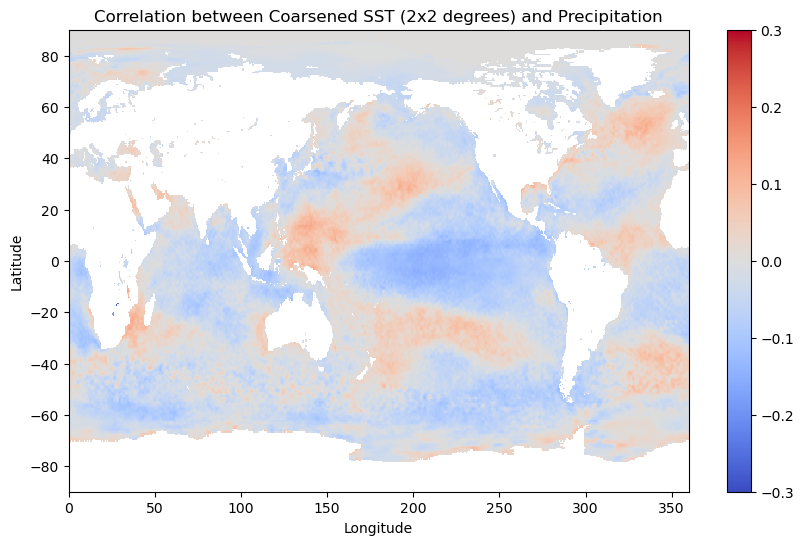

In [13]:
plt.figure(figsize=(10, 6))
correlation_map_xr.plot(cmap='coolwarm', vmin=-.3, vmax=.3)
plt.title('Correlation between Coarsened SST (2x2 degrees) and Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [12]:
correlation_map_xr.to_netcdf('/home/k16v981/my_work/data/era5/correlation_sst_precip_sa.nc')